In [1]:
# Cell 1: Setup & Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Import TrajectoryGenerator
from path_trajectory_pkg.trajectory_generator import TrajectoryGenerator

print("✓ Imports successful")
print("✓ TrajectoryGenerator loaded\n")


✓ Imports successful
✓ TrajectoryGenerator loaded



# Cell 2: Create Test Path Data (Simulating smooth_path.yaml output)

In [2]:
# Create a simple curved path with known properties
n_points = 100
s = np.linspace(0, 10, n_points)  # Path parameter

# S-curve path
x = s
y = 2 * np.sin(s / 2)

# Compute distances
dx = np.diff(x)
dy = np.diff(y)
distances = np.sqrt(dx**2 + dy**2)
distances = np.concatenate([[0], distances])  # First point has 0 distance
cumulative_distances = np.cumsum(distances)

# Compute curvature (approximate for testing)
# For smooth curve, use numerical differentiation
def compute_test_curvature(x, y, s):
    dx_ds = np.gradient(x, s)
    dy_ds = np.gradient(y, s)
    d2x_ds2 = np.gradient(dx_ds, s)
    d2y_ds2 = np.gradient(dy_ds, s)
    
    curvature = np.abs(dx_ds * d2y_ds2 - dy_ds * d2x_ds2) / (dx_ds**2 + dy_ds**2)**1.5
    return curvature

curvatures = compute_test_curvature(x, y, s)

# Store as path_data (simulating loaded YAML)
test_path_data = {
    'x': x,
    'y': y,
    'curvature': curvatures,
    'distances': distances,
    'cumulative_distances': cumulative_distances,
    'total_length': cumulative_distances[-1]
}

print("✓ Test path data created")
print(f"  - Points: {len(x)}")
print(f"  - Total length: {test_path_data['total_length']:.3f} m")
print(f"  - Max curvature: {np.max(curvatures):.4f} m⁻¹\n")


✓ Test path data created
  - Points: 100
  - Total length: 12.043 m
  - Max curvature: 0.4995 m⁻¹



# Cell 3: Test Main Functions

In [3]:


# Create a mock TrajectoryGenerator instance for testing
# We'll test the core algorithm functions directly

print("="*60)
print("TESTING MAIN FUNCTIONS")
print("="*60)

# Test parameters
v_max = 0.8
a_max = 0.45
a_lat_max = 0.7

# Test 1: compute_curvature_velocity_limit()
print("\n[1] Testing compute_curvature_velocity_limit()")

def compute_curvature_velocity_limit(curvatures, a_lat_max, v_max):
    """Compute velocity limit based on curvature."""
    curvatures_safe = np.maximum(curvatures, 1e-6)
    v_from_curvature = np.sqrt(a_lat_max / curvatures_safe)
    v_limit = np.minimum(v_from_curvature, v_max)
    return v_limit

v_limit = compute_curvature_velocity_limit(test_path_data['curvature'], a_lat_max, v_max)

print(f"   Max velocity limit: {np.max(v_limit):.3f} m/s")
print(f"   Min velocity limit: {np.min(v_limit):.3f} m/s")
if np.all(v_limit <= v_max):
    print("   ✅ PASS (all limits ≤ v_max)")
else:
    print("   ❌ FAIL (some limits > v_max)")

# Test 2: forward_pass()
print("\n[2] Testing forward_pass()")

def forward_pass(v_limit, distances, a_max):
    """Forward integration: acceleration-limited."""
    n = len(v_limit)
    v_forward = np.zeros(n)
    v_forward[0] = 0.0  # Start from rest
    
    for i in range(n - 1):
        v_accel = np.sqrt(v_forward[i]**2 + 2 * a_max * distances[i+1])
        v_forward[i + 1] = min(v_accel, v_limit[i + 1])
    
    return v_forward

v_forward = forward_pass(v_limit, test_path_data['distances'], a_max)

print(f"   Start velocity: {v_forward[0]:.3f} m/s")
print(f"   Max velocity: {np.max(v_forward):.3f} m/s")
if v_forward[0] == 0.0:
    print("   ✅ PASS (starts from rest)")
else:
    print("   ❌ FAIL (doesn't start from rest)")

# Test 3: backward_pass()
print("\n[3] Testing backward_pass()")

def backward_pass(v_limit, distances, a_max):
    """Backward integration: deceleration-limited."""
    n = len(v_limit)
    v_backward = np.zeros(n)
    v_backward[-1] = 0.0  # End at rest
    
    for i in range(n - 1, 0, -1):
        v_decel = np.sqrt(v_backward[i]**2 + 2 * a_max * distances[i])
        v_backward[i - 1] = min(v_decel, v_limit[i - 1])
    
    return v_backward

v_backward = backward_pass(v_limit, test_path_data['distances'], a_max)

print(f"   End velocity: {v_backward[-1]:.3f} m/s")
print(f"   Max velocity: {np.max(v_backward):.3f} m/s")
if v_backward[-1] == 0.0:
    print("   ✅ PASS (ends at rest)")
else:
    print("   ❌ FAIL (doesn't end at rest)")

# Test 4: Optimal velocity (minimum of forward and backward)
print("\n[4] Testing optimal velocity profile")

v_optimal = np.minimum(v_forward, v_backward)

print(f"   Start velocity: {v_optimal[0]:.3f} m/s")
print(f"   End velocity: {v_optimal[-1]:.3f} m/s")
print(f"   Max velocity: {np.max(v_optimal):.3f} m/s")
if v_optimal[0] == 0.0 and v_optimal[-1] == 0.0:
    print("   ✅ PASS (starts and ends at rest)")
else:
    print("   ❌ FAIL (boundary conditions not met)")

# Test 5: compute_timestamps()
print("\n[5] Testing compute_timestamps()")

def compute_timestamps(velocities, distances):
    """Compute timestamps using harmonic mean."""
    n = len(velocities)
    timestamps = np.zeros(n)
    timestamps[0] = 0.0
    
    for i in range(n - 1):
        v1 = velocities[i]
        v2 = velocities[i + 1]
        
        if v1 > 1e-6 and v2 > 1e-6:
            v_avg = 2 * v1 * v2 / (v1 + v2)
        else:
            v_avg = (v1 + v2) / 2.0
        
        v_avg = max(v_avg, 1e-6)
        dt = distances[i + 1] / v_avg
        timestamps[i + 1] = timestamps[i] + dt
    
    return timestamps

timestamps = compute_timestamps(v_optimal, test_path_data['distances'])

print(f"   Total time: {timestamps[-1]:.3f} s")
print(f"   Average speed: {test_path_data['total_length']/timestamps[-1]:.3f} m/s")
if timestamps[0] == 0.0 and np.all(np.diff(timestamps) >= 0):
    print("   ✅ PASS (timestamps monotonic and start at 0)")
else:
    print("   ❌ FAIL (timestamp issues)")

# Test 6: compute_accelerations()
print("\n[6] Testing compute_accelerations()")

def compute_accelerations(velocities, timestamps):
    """Compute accelerations from velocity profile."""
    dt = np.diff(timestamps)
    dv = np.diff(velocities)
    dt = np.where(dt < 1e-6, 1e-6, dt)
    accelerations = dv / dt
    accelerations = np.concatenate([accelerations, [0.0]])
    return accelerations

accelerations = compute_accelerations(v_optimal, timestamps)

max_accel = np.max(np.abs(accelerations))
print(f"   Max acceleration: {max_accel:.3f} m/s²")
print(f"   Threshold: {a_max:.3f} m/s²")
if max_accel <= a_max + 0.1:  # Allow small tolerance
    print("   ✅ PASS (acceleration within limits)")
else:
    print("   ❌ FAIL (acceleration exceeds limits)")

# Test 7: Constraint validation
print("\n[7] Testing constraint validation")

# Velocity constraint
max_vel = np.max(v_optimal)
vel_ok = max_vel <= v_max + 0.01

# Acceleration constraint
accel_ok = max_accel <= a_max + 0.1

# Lateral acceleration constraint
lateral_ok = True
for i in range(len(test_path_data['curvature'])):
    k = test_path_data['curvature'][i]
    v = v_optimal[i]
    if k > 1e-6:
        a_lat = v**2 * k
        if a_lat > a_lat_max + 0.05:
            lateral_ok = False
            break

print(f"   Velocity constraint: {'✅ PASS' if vel_ok else '❌ FAIL'}")
print(f"   Acceleration constraint: {'✅ PASS' if accel_ok else '❌ FAIL'}")
print(f"   Lateral accel constraint: {'✅ PASS' if lateral_ok else '❌ FAIL'}")

print("\n" + "="*60)
print("FUNCTION TESTS COMPLETE")
print("="*60 + "\n")


TESTING MAIN FUNCTIONS

[1] Testing compute_curvature_velocity_limit()
   Max velocity limit: 0.800 m/s
   Min velocity limit: 0.800 m/s
   ✅ PASS (all limits ≤ v_max)

[2] Testing forward_pass()
   Start velocity: 0.000 m/s
   Max velocity: 0.800 m/s
   ✅ PASS (starts from rest)

[3] Testing backward_pass()
   End velocity: 0.000 m/s
   Max velocity: 0.800 m/s
   ✅ PASS (ends at rest)

[4] Testing optimal velocity profile
   Start velocity: 0.000 m/s
   End velocity: 0.000 m/s
   Max velocity: 0.800 m/s
   ✅ PASS (starts and ends at rest)

[5] Testing compute_timestamps()
   Total time: 16.858 s
   Average speed: 0.714 m/s
   ✅ PASS (timestamps monotonic and start at 0)

[6] Testing compute_accelerations()
   Max acceleration: 0.450 m/s²
   Threshold: 0.450 m/s²
   ✅ PASS (acceleration within limits)

[7] Testing constraint validation
   Velocity constraint: ✅ PASS
   Acceleration constraint: ✅ PASS
   Lateral accel constraint: ✅ PASS

FUNCTION TESTS COMPLETE



# Cell 4: Comprehensive Visualization

✓ Visualization complete
✓ Saved as: trajectory_generator_test_results.png



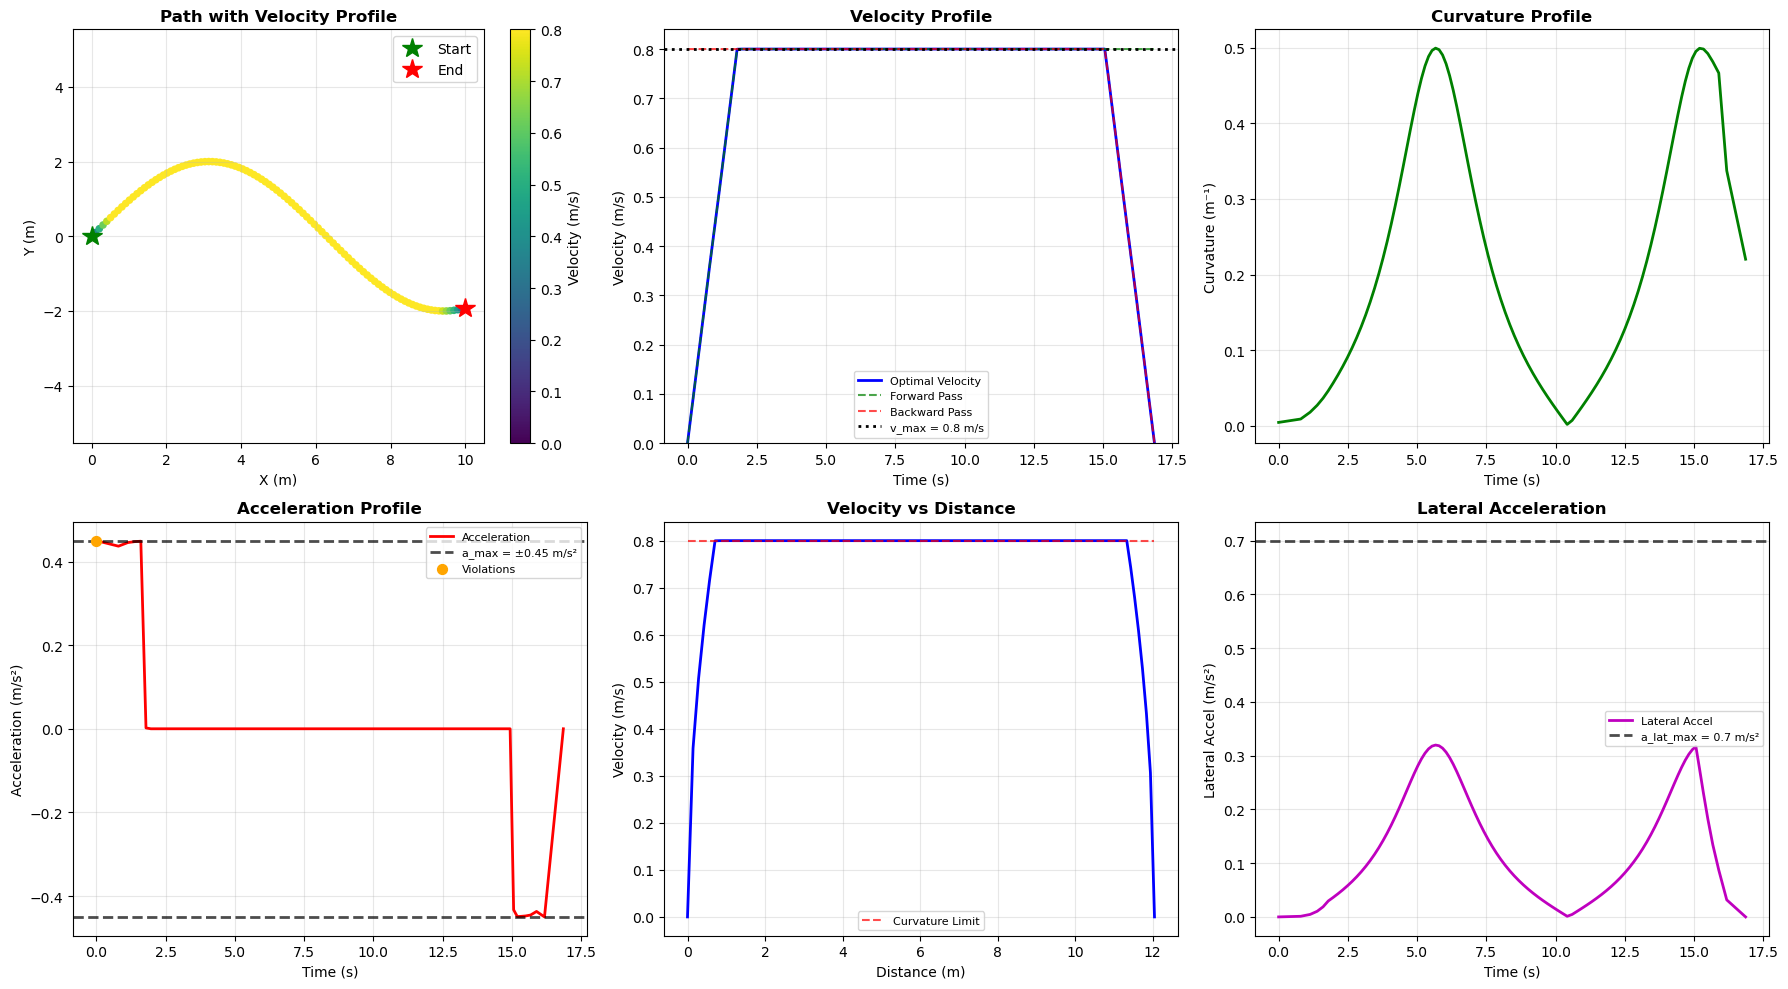

In [4]:


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Path with velocity colormap
ax = axes[0, 0]
scatter = ax.scatter(test_path_data['x'], test_path_data['y'], 
                     c=v_optimal, cmap='viridis', s=30, edgecolors='none')
ax.plot(test_path_data['x'][0], test_path_data['y'][0], 'g*', 
        markersize=15, label='Start')
ax.plot(test_path_data['x'][-1], test_path_data['y'][-1], 'r*', 
        markersize=15, label='End')
ax.set_xlabel('X (m)', fontsize=10)
ax.set_ylabel('Y (m)', fontsize=10)
ax.set_title('Path with Velocity Profile', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.colorbar(scatter, ax=ax, label='Velocity (m/s)')

# Plot 2: Velocity vs Time
ax = axes[0, 1]
ax.plot(timestamps, v_optimal, 'b-', linewidth=2, label='Optimal Velocity')
ax.plot(timestamps, v_forward, 'g--', linewidth=1.5, alpha=0.7, label='Forward Pass')
ax.plot(timestamps, v_backward, 'r--', linewidth=1.5, alpha=0.7, label='Backward Pass')
ax.axhline(y=v_max, color='k', linestyle=':', linewidth=2, label=f'v_max = {v_max} m/s')
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Velocity (m/s)', fontsize=10)
ax.set_title('Velocity Profile', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

# Plot 3: Curvature vs Time
ax = axes[0, 2]
ax.plot(timestamps, test_path_data['curvature'], 'g-', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Curvature (m⁻¹)', fontsize=10)
ax.set_title('Curvature Profile', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Acceleration vs Time
ax = axes[1, 0]
ax.plot(timestamps, accelerations, 'r-', linewidth=2, label='Acceleration')
ax.axhline(y=a_max, color='k', linestyle='--', linewidth=2, 
           label=f'a_max = ±{a_max} m/s²', alpha=0.7)
ax.axhline(y=-a_max, color='k', linestyle='--', linewidth=2, alpha=0.7)

# Highlight violations
violations = np.abs(accelerations) > a_max
if np.any(violations):
    ax.scatter(timestamps[violations], accelerations[violations], 
               color='orange', s=50, zorder=5, label='Violations')

ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Acceleration (m/s²)', fontsize=10)
ax.set_title('Acceleration Profile', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Velocity vs Distance
ax = axes[1, 1]
ax.plot(test_path_data['cumulative_distances'], v_optimal, 'b-', linewidth=2)
ax.plot(test_path_data['cumulative_distances'], v_limit, 'r--', 
        linewidth=1.5, alpha=0.7, label='Curvature Limit')
ax.set_xlabel('Distance (m)', fontsize=10)
ax.set_ylabel('Velocity (m/s)', fontsize=10)
ax.set_title('Velocity vs Distance', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Lateral Acceleration
ax = axes[1, 2]
lateral_accels = v_optimal**2 * test_path_data['curvature']
ax.plot(timestamps, lateral_accels, 'm-', linewidth=2, label='Lateral Accel')
ax.axhline(y=a_lat_max, color='k', linestyle='--', linewidth=2,
           label=f'a_lat_max = {a_lat_max} m/s²', alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Lateral Accel (m/s²)', fontsize=10)
ax.set_title('Lateral Acceleration', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory_generator_test_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualization complete")
print("✓ Saved as: trajectory_generator_test_results.png\n")
plt.show()
